Generating to C:\Users\ZULQAR~1\AppData\Local\Temp\gen_py\3.7\8BFDE413-245A-4514-B151-B16DCC243796x0x1x0.py
Building definitions from type library...
Generating...
Importing module


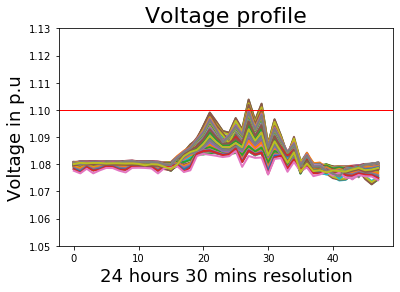

Customers in this seed:  [157, 114, 159, 323, 167, 58, 293, 74, 107, 286, 80, 210, 128, 0, 95, 104, 240, 107, 268, 260, 26, 9, 304, 70, 75, 208, 207, 158, 14, 31, 194, 2, 121, 296, 125, 194, 176, 306, 127, 193, 312, 160, 214, 134, 141, 66, 129, 173, 333, 332, 135, 235, 56, 185, 244, 275, 234, 329, 42, 40, 196, 107, 301, 315, 102, 215, 40, 238, 142, 127, 340, 3, 283, 190, 17, 245, 95, 296, 192, 307, 182, 36, 175, 333, 241, 228, 32, 54, 86] 89
The customers with allocated PV profiles are: ['load_mg1_54', 'load_mg1_61', 'load_mg1_56', 'load_mg1_76', 'load_mg1_60', 'load_mg1_65', 'load_mg1_49', 'load_mg1_80', 'load_mg1_67', 'load_mg1_86', 'load_mg1_44', 'load_mg1_29', 'load_mg1_28', 'load_mg1_17', 'load_mg1_23', 'load_mg1_71', 'load_mg1_31', 'load_mg1_8', 'load_mg1_21', 'load_mg1_8', 'load_mg1_38', 'load_mg1_46', 'load_mg1_3', 'load_mg1_85', 'load_mg1_6', 'load_mg1_86', 'load_mg1_3', 'load_mg1_1', 'load_mg1_70', 'load_mg1_75', 'load_mg1_49', 'load_mg1_74', 'load_mg1_30', 'load_mg1_17', 'lo

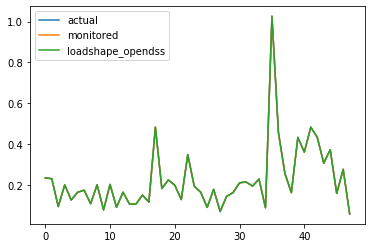

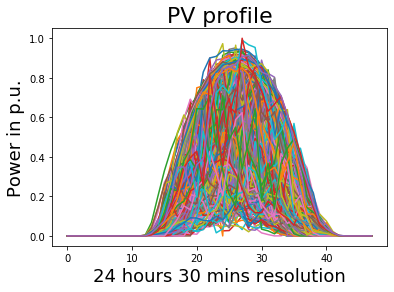

In [6]:
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 16 16:54:20 2019

@author: Angela
"""
# from comtypes import client as cc
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import math
#import sys                                     #this is to enable early binding
#from win32com.client import makepy
#sys.argv = ["makepy", "OpenDSSEngine.DSS"]        #creates virtual table - vtable
#makepy.main()
#Obj = cc.CreateObject("OpenDSSEngine.DSS")

## Define the path where files are located
#mydir = 'C:\\OpenDSS-Training-DrNando\\chapter3\\OpenDSS_Files_TR1'   #Set Directoty

import DSSStartup as dsss
DSSStartOK, DSSObj, DSSText = dsss.DSSStartup()
if not DSSStartOK:
    print('Unable to start the OpenDSS Engine')
    import sys
    sys.exit()

#Start=Obj.Start(0)
DSSText=DSSObj.Text
#DSSStartOK=Start
#DSSObj=Obj
#DSSText=Text

  #   Set up the Text
DSSText.Command = 'Clear'                                 #   Clear text command
DSSText.Command = 'Compile Master.txt'    #In Python strings are concatenated with the operator "+" e.g. 'Hello,' + ' World!' = 'Hello, World!'
#clear all
#DSSText.Command = 'Set DefaultBaseFrequency=50'
#DSSText.Command = 'New circuit.LV_grid basekv=22.0 pu=1.00 angle=0 frequency=50 phases=3'
#DSSText.Command = 'Redirect MG1_transformers.txt'
#DSSText.Command = 'Redirect linecodes.txt'
#DSSText.Command = 'Redirect MG1_lines.txt'
#DSSText.Command = 'Redirect MG1_serviceLines.txt'
#DSSText.Command = 'Redirect MG1_loads.txt'



DSSText.Command = 'Set VoltageBases = [22.0, 0.400]'
DSSText.Command = 'calcvoltagebases'

DSSCircuit = DSSObj.ActiveCircuit                                    #   Set up the Circuit
DSSSolution = DSSCircuit.Solution                                    #   Set up the Solution
ControlQueue = DSSCircuit.CtrlQueue
DSSElem=DSSCircuit.ActiveCktElement  
DSSBus=DSSCircuit.ActiveBus                                         #   Set up the Control
DSSObj.AllowForms = 0 

#Loading Load and PV profiles

houseData30minutes = np.load('House data - 30 mins resolution.npy') 
shape_profiles  = houseData30minutes.shape
noProfiles = shape_profiles[0]

PVData30minutes = np.load('PV data - 30 mins resolution.npy') #Select this if you want the 30 minutes resolution


##  Initialization of customers and loadshapes
for icust, cust in enumerate(DSSCircuit.Loads.AllNames):
    random_profile = np.random.randint(0,noProfiles)
    load_profile = np.zeros(48) # houseData30minutes[random_profile, iday, :]
    DSSCircuit.LoadShapes.New('customer_profile_%s' %(icust))
    DSSCircuit.LoadShapes.Name = 'customer_profile_%s' %(icust)
    DSSCircuit.LoadShapes.Npts = 48
    DSSText.Command = 'interval = 30m'
    DSSCircuit.LoadShapes.UseActual = 1
    DSSCircuit.LoadShapes.Pmult = load_profile.tolist()
    DSSCircuit.LoadShapes.Qmult = (load_profile * math.tan(math.acos(0.98))).tolist()
    
    DSSCircuit.SetActiveElement('load.%s'%(cust))
    DSSCircuit.ActiveElement.Properties('daily').Val = str('customer_profile_%s' %(icust))
#    
    #PV systems
    PV_profile=np.zeros(48) #PVData30minutes[icust,:]#
    DSSCircuit.LoadShapes.New('pv_profile_%s' %(icust))
    DSSCircuit.LoadShapes.Name = 'pv_profile_%s' %(icust)
    DSSCircuit.LoadShapes.Npts = 48
    #DSSText.Command = 'interval = 30m'
    DSSCircuit.LoadShapes.UseActual = 1
    DSSCircuit.LoadShapes.Pmult = PV_profile.tolist()
    DSSCircuit.SetActiveElement('load.%s' %(cust))
    bus_name = DSSCircuit.ActiveElement.Properties('bus1').Val
    DSSText.Command = 'new PVSystem.%s'%(icust)\
                                + ' phases=1'  \
                                + ' irradiance=1' \
                                + ' %cutin=0.05' \
                                + ' %cutout=0.05' \
                                + ' vmaxpu=1.5' \
                                + ' vminpu=0.5' \
                                + ' kva=5' \
                                + ' pmpp=4.5'\
                                + ' bus1=' + str(bus_name)\
                                + ' pf=1' \
                                + ' kv=0.23' \
                                + ' daily=' +str('pv_profile_%s'%(icust))
                                
plot_day=[50] 
rand_cust=[]
#Set the penetration:
penetration=100
num_cust=len(DSSCircuit.Loads.AllNames)*(penetration/100)
customers=len(DSSCircuit.Loads.AllNames)

#START
for iday in range(50,51):
    df_kw=pd.DataFrame()
    df_kvar=pd.DataFrame()
    df_volt=pd.DataFrame()
    load_profiles_all = []
    pv_profiles_all = []
    random_profiles_all=[]
    np.random.seed(90)
    numb=0
    rand_cust=[]

    for icust, cust in enumerate(DSSCircuit.Loads.AllNames):
        
        random_profile = np.random.randint(0,noProfiles)
        random_profiles_all.append(random_profile)
        load_profile = houseData30minutes[random_profile, iday, :]
        load_profiles_all.append(load_profile)
        
        DSSCircuit.LoadShapes.Name = 'customer_profile_%s' %(icust)
        
        DSSCircuit.LoadShapes.Pmult = load_profile.tolist()
        DSSCircuit.LoadShapes.Qmult = (load_profile * math.tan(math.acos(0.95))).tolist() #(load_profile * math.tan(math.acos(0.98))).tolist()
        DSSCircuit.SetActiveElement('load.%s'%(cust))
        DSSCircuit.ActiveElement.Properties('daily').Val = str('customer_profile_%s' %(icust)) 
        
        random.seed(90)
    #allocation of PV to 10 - 100% , defined by penetration     
    for numb in range(round(num_cust)):
             
        PV_profile=PVData30minutes[iday, :]
        pv_profiles_all.append(PV_profile)
        
        DSSCircuit.LoadShapes.Name = 'pv_profile_%s' %(numb)
        DSSCircuit.LoadShapes.Pmult = PV_profile.tolist()
        
        random_customer=np.array(DSSCircuit.Loads.AllNames)
        random.shuffle(random_customer)
        rand_cust.append(random_customer[numb])
        
        DSSCircuit.SetActiveElement('load.%s' %(random_customer[numb]))
        bus_name = DSSCircuit.ActiveElement.Properties('bus1').Val 
        DSSText.Command = 'new PVSystem.%s'%(numb)\
                                + ' phases=1'  \
                                + ' irradiance=1' \
                                + ' %cutin=0.05' \
                                + ' %cutout=0.05' \
                                + ' vmaxpu=1.5' \
                                + ' vminpu=0.5' \
                                + ' kva=5' \
                                + ' pmpp=4.5'\
                                + ' bus1=' + str(bus_name)\
                                + ' pf=1' \
                                + ' kv=0.23' \
                                + ' daily=' +str('pv_profile_%s'%(numb))
                    

    #DSSText.Command = 'Set ControlMode = time'
    #DSSText.Command = 'Reset'                                                      #    resetting all energy meters and monitors
    DSSText.Command = 'Set Mode=daily  number=1' 
    
    voltages_monitors = np.zeros((customers,48))
    kW_monitors = np.zeros((customers,48))
    kvar_monitors = np.zeros((customers,48))
    
    for itime in range(48):
        DSSSolution.Solve()
        for icust, cust in enumerate(DSSCircuit.Loads.AllNames):
            DSSCircuit.SetActiveElement('load.%s' %(cust))
            kW_monitors[icust, itime] = DSSCircuit.ActiveElement.Powers[0]
            kvar_monitors[icust,itime]= DSSCircuit.ActiveElement.Powers[1]
            bus_name = DSSCircuit.ActiveElement.Properties('bus1').Val
            DSSCircuit.SetActiveBus(bus_name)
            voltages_monitors[icust, itime] = DSSCircuit.ActiveBus.puVmagAngle[0]
            
    df_kw=pd.DataFrame(kW_monitors)
    df_kvar=pd.DataFrame(kvar_monitors)
    df_volt=pd.DataFrame(voltages_monitors)
        
    writer = pd.ExcelWriter('day_%s.xlsx'%(iday), engine='xlsxwriter')
    
    df_kw.to_excel(writer, sheet_name='P')
    df_kvar.to_excel(writer, sheet_name='Q')
    df_volt.to_excel(writer, sheet_name='V')
    writer.save()
    writer.close()
           
#if we want to plot every profile, or with specific days, we can plot only those days   
#    
    if iday in plot_day:
        for idx, row in df_volt.iterrows():
             plt.figure("Day %s"%iday)
             plt.plot(np.array(row), linewidth=2)         
             plt.xlabel('24 hours 30 mins resolution', fontsize=18)
             plt.xticks(fontsize=10)
             plt.ylabel('Voltage in p.u', fontsize=18)
             plt.yticks(fontsize=10)
             plt.title('Voltage profile', fontsize=22)
             plt.ylim([1.05,1.13])
             plt.axhline(1.10,linewidth=1, color='r')
plt.show()

             
print("Customers in this seed: ",random_profiles_all,customers)     
print("The customers with allocated PV profiles are:" ,rand_cust)

#checking if it's the same    
plt.figure(500)
plt.plot(load_profiles_all[0], label='actual')
plt.plot(kW_monitors[0,:], label='monitored')
DSSCircuit.LoadShapes.Name = 'customer_profile_%s' %(0)
plt.plot(DSSCircuit.LoadShapes.Pmult, label='loadshape_opendss')
plt.legend()

#print(load_profiles_all[0])
plt.figure('pv profile')
for row in PVData30minutes:
    plt.plot(row, label='pv profiles')
    plt.xlabel('24 hours 30 mins resolution', fontsize=18)
    plt.xticks(fontsize=10)
    plt.ylabel('Power in p.u.', fontsize=18)
    plt.yticks(fontsize=10)
    plt.title('PV profile', fontsize=22)


if DSSSolution.Converged:
    print('Message2:the Solution Converged successfully\n')
else:
    print("Message3: the Solution did not Converged successfully\n")



    
    
    
    

In [2]:
pwd

'C:\\Program Files\\OpenDSS\\IEEETestCases\\13Bus'